# Imports and file loading

In [1]:
import sys
sys.path.append('/home/prestonh/Desktop/Research/pore_stats/lib/oi/')
sys.path.append('/home/prestonh/Desktop/Research/pore_stats/lib/rp/')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import matplotlib.animation as animation
%matplotlib inline
from scipy.ndimage.interpolation import rotate
from math import cos, sin
import time
import random
import string
import optical_imaging as oi
import copy
import oi_file
from scipy.ndimage.filters import gaussian_filter
import resistive_pulse as rp
import os
pi=3.14159
import cv2

# Jupyter
from IPython.display import HTML

In [5]:
#file_directory = '/home/prestonh/Desktop/Research/cancer_cells/data/xfer/'
file_directory = '/home/prestonh/Desktop/Research/cancer_cells/data/4-26-2017/pdms_oil/17p5_30_17p5/oi/bin/'
#file_directory = '/home/prestonh/Desktop/Research/cancer_cells/data/2-24-2017/17p5_30_17p5_4/oi/bin/'
file_name = 'test_camera_0'
file_path = file_directory + file_name
output_file_path = file_path + '_events.json'
vid = oi_file.Raw(file_path, 512, 288, 50000, 5)
#vid = oi_file.Raw(file_path, 640, 480, 50000, 5)

# Optimize alpha, beta

### Get frame with cluster

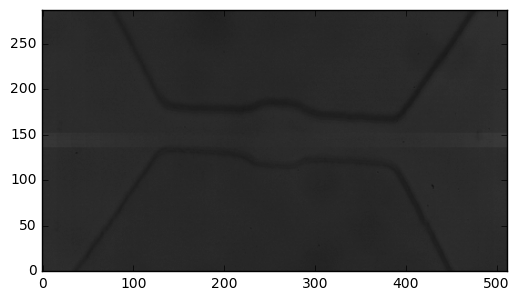

In [6]:
template_index = 0
template_frame = vid.get_frame(template_index)
plt.imshow(template_frame, cmap = 'gray', origin = 'lower', vmin = 0, vmax = 1)
plt.show()

In [7]:
threshold_difference = 0.02

print vid._total_frames

num_found = 0
for i in range(0, vid._total_frames):
    if i%1000 == 0:
        print i
    frame = vid.get_frame(i)
    clusters = oi.find_clusters_percentage_based(frame, template_frame, threshold_difference = threshold_difference)
    if(len(clusters)) > 0:
        print i
        num_found+=1
        if num_found > 5:
            #break
            pass
            

49974
0
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307


KeyboardInterrupt: 

In [3]:
reload(oi_file)

<module 'oi_file' from '/home/prestonh/Desktop/Research/pore_stats/lib/oi/oi_file.pyc'>

In [18]:
pause_frames = [6953, 6955]
pause_length = 10
start_frame = 6940
stop_frame = 6968



frames = range(start_frame,pause_frames[0])+\
        [pause_frames[0]]*pause_length +\
        range(pause_frames[0]+1,pause_frames[1])+\
        [pause_frames[1]]*pause_length+\
        range(pause_frames[1]+1,stop_frame+1)+\
        [stop_frame]*100 # Padding

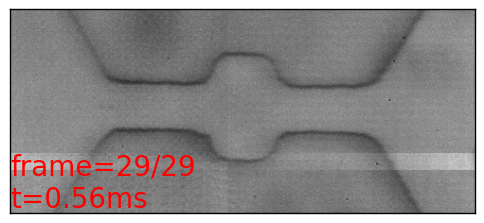

In [19]:
reload(oi_file)
HTML(oi_file.make_animation_frames(vid, frames).to_html5_video())

### Show image, template image, difference

1


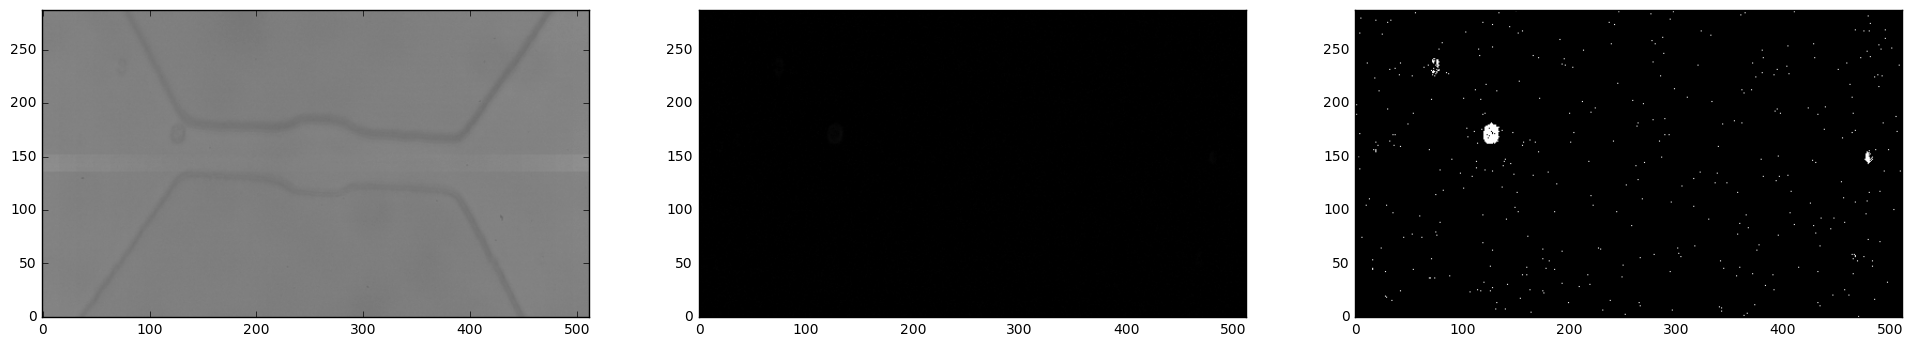

In [19]:
index = 310
template_frame = vid.get_frame(template_index)
frame = vid.get_frame(index)

threshold_difference = .015#.035
alpha = 1#2



beta = 'avg'    # -(np.mean(frame)-.5)
template_frame = oi.change_frame_contrast(template_frame, alpha = alpha, beta = beta)
frame = oi.change_frame_contrast(frame, alpha = alpha, beta = beta)


cluster_threshold = 200


neg_frame = abs(frame - template_frame)
clusters = oi.find_clusters_percentage_based(frame, template_frame, threshold_difference = threshold_difference,\
                                             cluster_threshold = cluster_threshold)
temp_neg_frame = copy.deepcopy(neg_frame[:,:])
temp_neg_frame[temp_neg_frame > threshold_difference] = 1
temp_neg_frame[temp_neg_frame <= threshold_difference] = 0

print len(clusters)
fig, axes = plt.subplots(1,3,figsize=(24,8))

# Raw image
plt.sca(axes[0])
plt.imshow(frame, cmap = 'gray', vmin = 0, vmax = 1, origin = 'lower')

# Negative
plt.sca(axes[1])
plt.imshow(neg_frame, cmap = 'gray', vmin = 0, vmax = 1, origin = 'lower')

# Thresholded negative
plt.sca(axes[2])
plt.imshow(temp_neg_frame, vmin = 0, vmax = 1, cmap = 'gray', origin = 'lower')

plt.show()

# Find events

In [20]:
reload(oi)
alpha = 1
beta = 'avg'
raw_events = oi.find_events(vid, ti = 0, template_frame = vid.get_frame(template_index), threshold_difference = threshold_difference, cluster_threshold = cluster_threshold, alpha = alpha, beta = 'avg')

/home/prestonh/Desktop/Research/pore_stats/lib/oi/optical_imaging.py:1026: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if template_frame == None:


t:  0 / 49974 	clusters: 0 	active: 0 	inactive: 0


/home/prestonh/Desktop/Research/pore_stats/lib/oi/optical_imaging.py:62: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if pixels != None:


t:  1000 / 49974 	clusters: 0 	active: 0 	inactive: 1
t:  2000 / 49974 	clusters: 0 	active: 0 	inactive: 1
t:  3000 / 49974 	clusters: 1 	active: 1 	inactive: 2
t:  4000 / 49974 	clusters: 0 	active: 0 	inactive: 3
t:  5000 / 49974 	clusters: 0 	active: 0 	inactive: 3
t:  6000 / 49974 	clusters: 0 	active: 0 	inactive: 3
t:  7000 / 49974 	clusters: 0 	active: 0 	inactive: 3
t:  8000 / 49974 	clusters: 0 	active: 0 	inactive: 3
t:  9000 / 49974 	clusters: 0 	active: 0 	inactive: 3
t:  10000 / 49974 	clusters: 0 	active: 0 	inactive: 10
t:  11000 / 49974 	clusters: 0 	active: 0 	inactive: 11
t:  12000 / 49974 	clusters: 0 	active: 0 	inactive: 11
t:  13000 / 49974 	clusters: 0 	active: 0 	inactive: 11
t:  14000 / 49974 	clusters: 0 	active: 0 	inactive: 11
t:  15000 / 49974 	clusters: 0 	active: 0 	inactive: 11
t:  16000 / 49974 	clusters: 0 	active: 0 	inactive: 11
t:  17000 / 49974 	clusters: 0 	active: 1 	inactive: 11
t:  18000 / 49974 	clusters: 0 	active: 0 	inactive: 12
t:  19000 

### Inspection

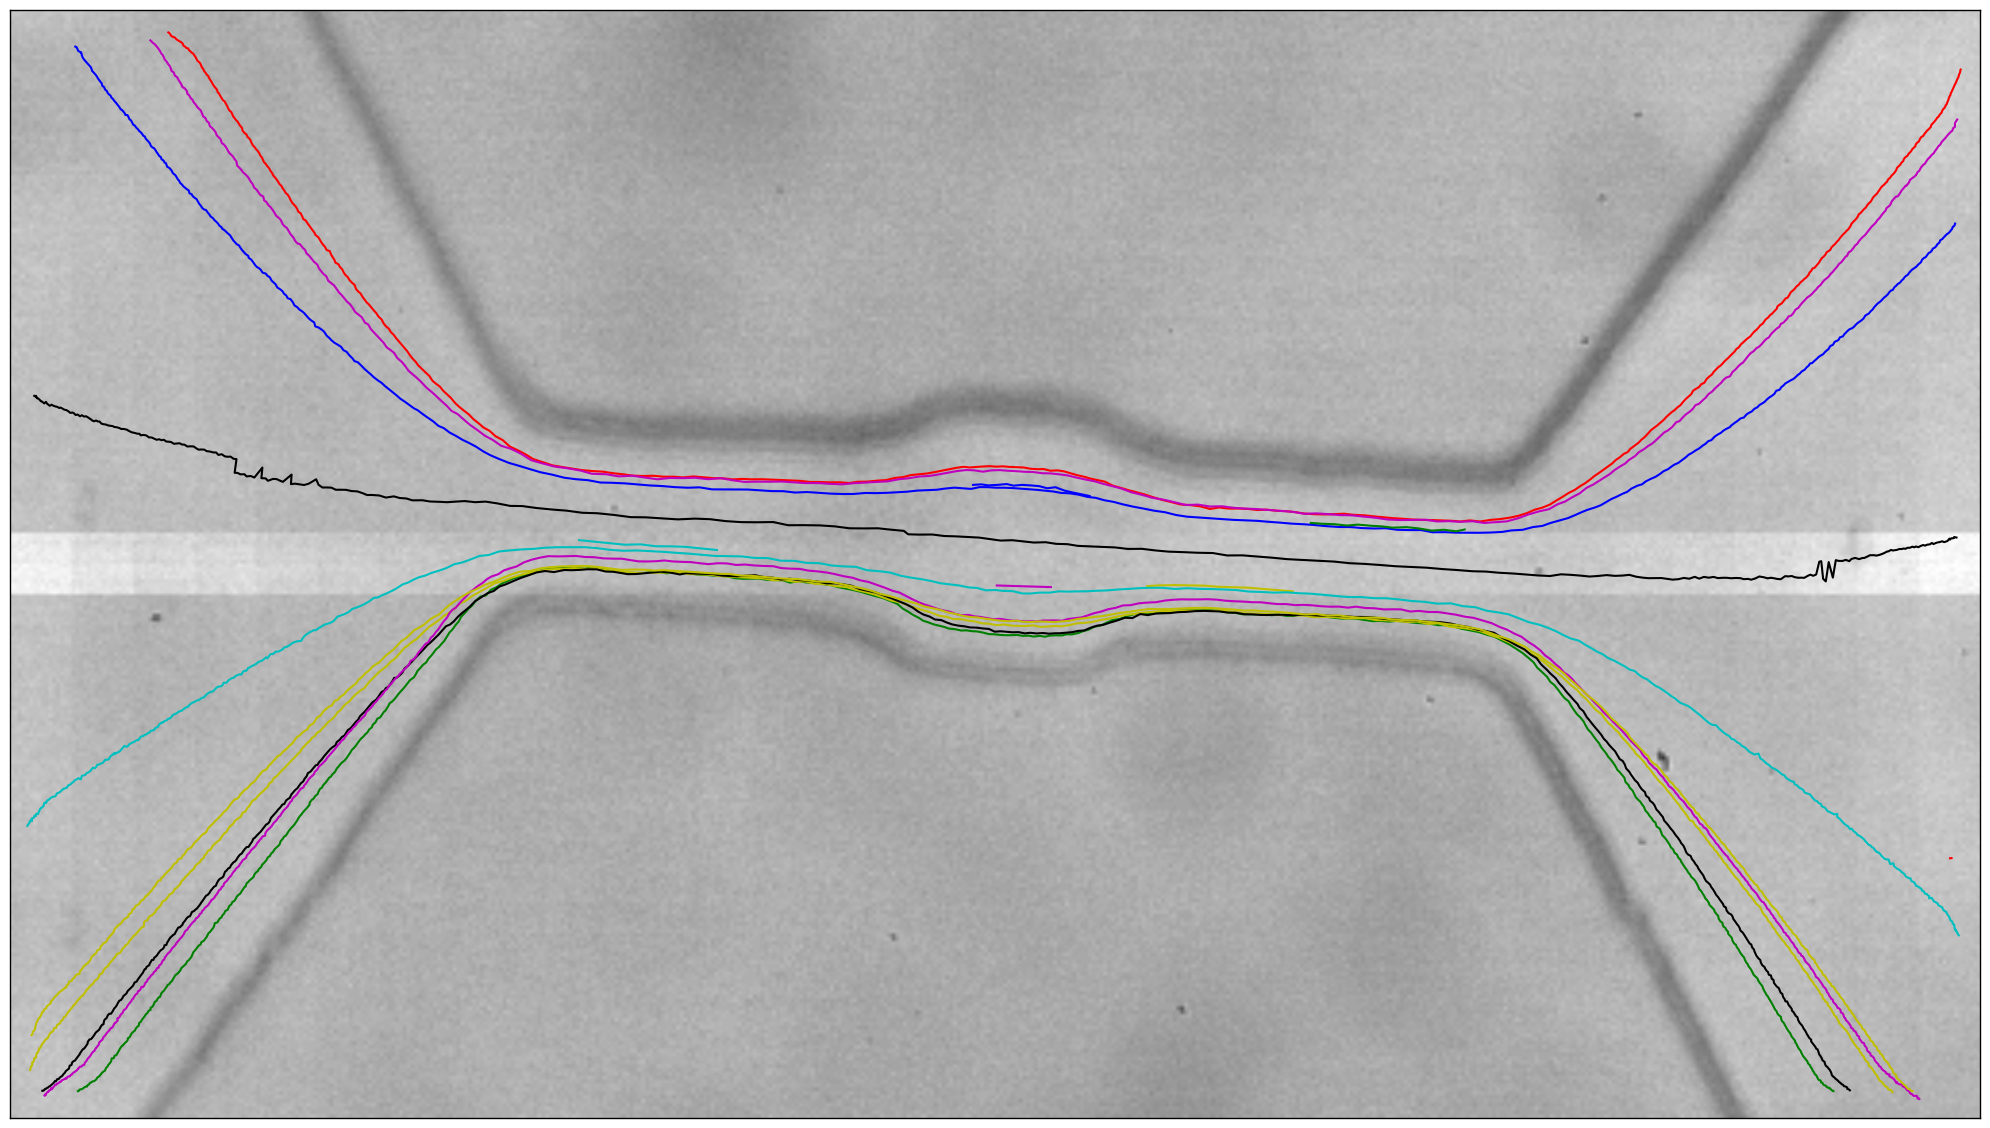

In [21]:
fig = plt.figure(figsize = (20,12))

#colors = cm.rainbow()

#gs = gs.GridSpec(2, 2)

for i, event in enumerate(raw_events[:]):
    px = []
    py = []
    for detection in event._detections:
        px.append(detection._px)
        py.append(detection._py)
    plt.plot(px, py, lw = 1.5)

plt.imshow(template_frame, alpha=0.8, cmap = 'gray', origin = 'lower')
plt.xticks([])
plt.yticks([])

fig.tight_layout()

#plt.savefig('/home/preston/Desktop/Science/Research/cancer_cells/10-5-2016_10um_0_10000fps.png', dpi = 300)

plt.show()

##### Save events

In [22]:
print output_file_path

/home/prestonh/Desktop/Research/cancer_cells/data/4-26-2017/pdms_oil/17p5_30_17p5/oi/bin/test_camera_0_events.json


In [23]:
oi_file.save_oi_events_json(output_file_path, raw_events)

In [89]:
(7-6)*10**(-3.)/((350-175)*10**(-6.))

5.714285714285714